In [13]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import os
import glob
import sys
sys.path.insert(0, '../scripts/')
from football_field import create_football_field
from plots import plot_play
import math

%matplotlib inline
pd.options.display.max_columns = 100

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
pprd

,Season_Year,GameKey,PlayID
0,2016,10,1275
1,2016,10,1409
2,2016,10,1501
3,2016,10,2693
4,2016,10,2810
5,2016,10,3228
6,2016,10,3432
7,2016,10,3790
8,2016,10,3878
9,2016,10,3981


In [ ]:
df = pd.read_parquet('../working/max_risk_partners.parquet')
vr = pd.read_csv('../working/video_review-detailed.csv')
pi = pd.read_parquet('../working/play_information_detailed.parquet')
pprd = pd.read_parquet('../working/punt_play_role_data_pivoted.parquet')

In [16]:
injury_risk_factor =pd.merge(vr,
                             df,
                             left_on=['Season_Year','GameKey','PlayID','GSISID','Primary_Partner_GSISID'],
                             right_on=['season_year','gamekey','playid','gsisid','gsisid_partner'],
                             how='left')

In [17]:
risk_metrics_by_rolepair = df.groupby(['role','role_partner'])['risk_factor'].agg([np.mean, np.std, 'count']).reset_index()

In [18]:
risk = pd.merge(df, risk_metrics_by_rolepair, suffixes=('','_risk_factor_pair'))

In [55]:
high_high_risk = risk.loc[(risk['count'] > 100) &
                          ((risk['mean'] + risk['std']) < risk['risk_factor']) &
                          (risk['risk_factor'] > 1000)].copy()

high_high_risk.loc[~high_high_risk[['season_year', 'gamekey', 'playid']].duplicated()].shape
high_high_risk['count'] = 1

In [56]:
play_risk_values = high_high_risk.groupby(['season_year', 'gamekey', 'playid']).agg('count')[['count']].reset_index().sort_values('count', ascending=False)

In [57]:
play_with_risk = pd.merge(pi, play_risk_values, left_on=['season_year','gamekey','playid'],
        right_on=['season_year','gamekey','playid'], how='left').fillna(0).sort_values('count', ascending=False)
play_with_risk = play_with_risk.rename(columns={'count':'risk_factor'})

In [68]:
play_with_risk[['season_year','gamekey','playid']].dtypes

season_year    int64
gamekey        int64
playid         int64
dtype: object

In [76]:
play_with_risk = pd.merge(play_with_risk, pprd, left_on=['season_year','gamekey','playid'],
         right_on=['Season_Year', 'GameKey', 'PlayID'])

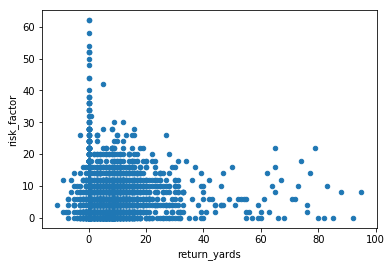

In [79]:
play_with_risk.plot(x='return_yards', y='risk_factor', kind='scatter')

In [83]:
play_with_risk.sort_values('risk_factor', ascending=False).to_csv('../working/play_with_risk_positions.csv')

In [84]:
play_with_risk[['']]

,season_year,season_type,gamekey,game_date,week,playid,game_clock,yardline,quarter,play_type,poss_team,home_team_visit_team,score_home_visiting,playdescription,No Play,PENALTY,declined,Offensive Holding,Defensive 12 On-field,Illegal Block Above the Waist,Fair Catch Interference,Running Into the Kicker,Unnecessary Roughness,Illegal Touch Kick,Illegal Use of Hands,False Start,Out of Bounds on Punt,Horse Collar Tackle,Face Mask,Ineligible Downfield Kick,Illegal Substitution,Illegal Formation,Delay of Game,Illegal Blindside Block,Neutral Zone Infraction,Tripping,Defensive Holding,Roughing the Kicker,Unsportsmanlike Conduct,Defensive Offside,Interference with Opportunity to Catch,Illegal Motion,Chop Block,Clipping,Invalid Fair Catch Signal,Illegal Shift,Offensive 12 On-field,Taunting,Offensive Pass Interference,Disqualification,Defensive Pass Interference,REVERSED,out of bounds,Touchback,fair catch,MUFF,downed,BLOCKED,TOUCHDOWN,no gain,FUMBLES,pass incomplete,Returned,returned for,return_yards,risk_factor,Season_Year,GameKey,PlayID
0,2017,Reg,588,12/03/2017,13,116,14:10,NYG 28,1,Punt,NYG,OAK-NYG,0 - 0,"(14:10) B.Wing punts 51 yards to OAK 21, Cente...",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,0,0.0,62.0,2017,588,116
1,2017,Reg,508,10/29/2017,8,2398,13:20,BUF 32,3,Punt,BUF,BUF-OAK,14 - 7,"(13:20) C.Schmidt punts 55 yards to OAK 13, Ce...",False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,0,0.0,62.0,2017,508,2398
2,2016,Reg,159,10/23/2016,7,1890,02:19,NYG 37,2,Punt,NYG,LA-NYG,10 - 10,(2:19) (Punt formation) B.Wing punts 49 yards ...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,0,0.0,58.0,2016,159,1890
3,2017,Reg,416,09/17/2017,2,2415,12:20,BLT 49,3,Punt,BLT,BLT-CLV,21 - 7,(12:20) (Punt formation) S.Koch punts 33 yards...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,0,0.0,54.0,2017,416,2415
4,2017,Reg,575,11/30/2017,13,596,04:37,DAL 25,1,Punt,DAL,DAL-WAS,0 - 0,(4:37) (Punt formation) C.Jones punts 42 yards...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,0,0.0,52.0,2017,575,596
5,2016,Reg,128,10/03/2016,4,355,09:20,MIN 8,1,Punt,MIN,MIN-NYG,0 - 0,(9:20) (Punt formation) J.Locke punts 53 yards...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,0,0.0,52.0,2016,128,355
6,2016,Reg,250,12/04/2016,13,741,02:33,NE 43,1,Punt,NE,NE-LA,7 - 0,"(2:33) R.Allen punts 39 yards to LA 18, Center...",False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,F